*Step 1: Importing modules*

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
import itertools 
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

*Step 2: Load datasets*

In [2]:
X = np.load('../input/X.npy') # images
Y = np.load('../input/Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

*Step 3: Describing the data in the datasets*

In [3]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


*Step 4: Plotting data*

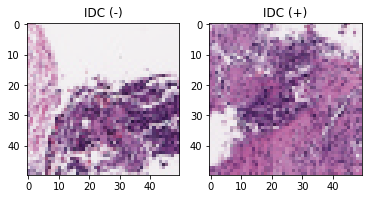

In [4]:
imgs0 = X[Y==0] # (0 = no IDC, 1 = IDC)
imgs1 = X[Y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 


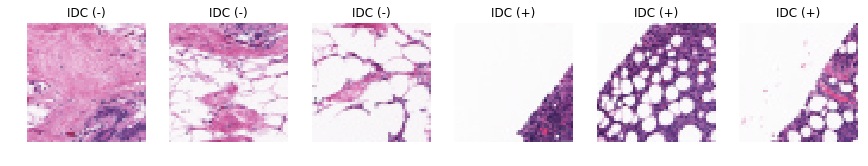

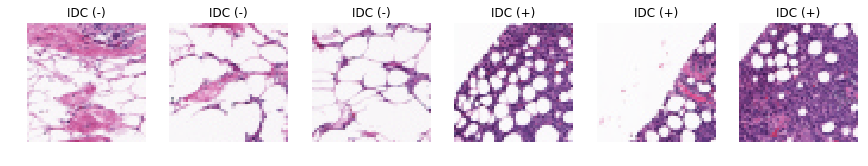

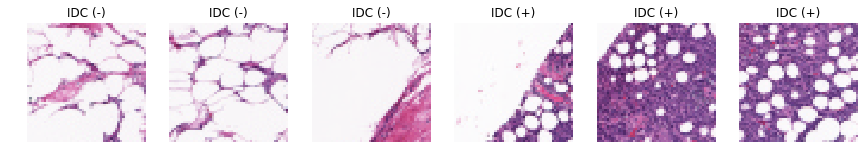

In [5]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 


*Step 4: Plotting histogram of an image in the dataset*

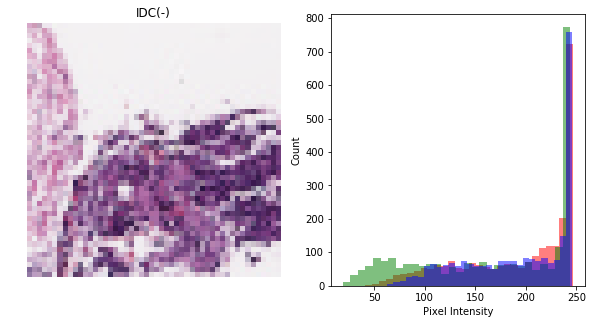

In [6]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[100])

*Data scaled from 0 to 256 converted to data scaled from 0 to 1. This makes data compatible with different classification algorithms. 20% for k-fold cross validation.*

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)


Training Data Shape: (4437, 50, 50, 3) (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3) (1110, 50, 50, 3)


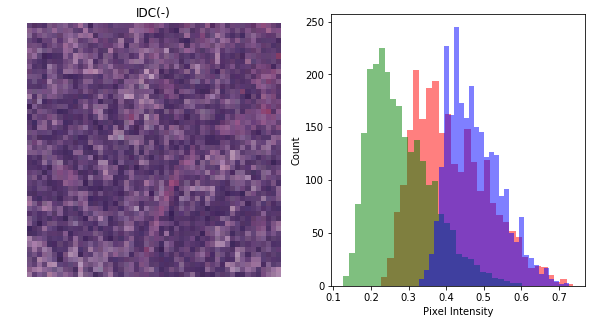

In [8]:
plotHistogram(X_train[100])

*Step 5: Evaluating classification algorithms*

In [9]:
# Make Data 1D for compatability with standard classifiers

X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [10]:
#runLogisticRegression
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

LogisticRegression - Training set accuracy: 0.703603603604 (0.0387387387387)




Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.703604 (0.038739)
RF: 0.734234 (0.028275)
KNN: 0.704505 (0.026358)
SVM: 0.718919 (0.030096)
LSVM: 0.693694 (0.024836)


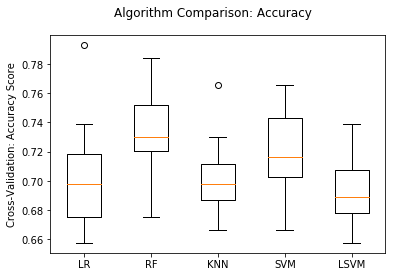


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC



In [11]:
# Comparing performance (calculating accuracy) of classification algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
   
      
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
   
    print('')
    return
defineModels()